![](http://cl.ly/YS6s/cyrest.001.png)

by [Keiichiro Ono](http://keiono.github.io/)

----

# Goal: Scalable & Reproducible Analysis
__Make Cytoscape external tool friendly__

## Cytoscape Session File = Result


## IPython Notebook + cyREST = Process

----
## New to IPython Notebook?
__There is a great Nature article about this technology:__

### [Interactive notebooks: Sharing the code](http://www.nature.com/news/interactive-notebooks-sharing-the-code-1.16261)
The free IPython notebook makes data analysis easier to record, understand and reproduce.

by Helen Shen 05 November 2014

----

# Core Idea: Access Cytoscape via tools/languages of your choice

![](http://cl.ly/YTR0/rest2.png)

In [1]:
import requests # Best REST client for Python!
import json # Standard toolkit to do something with JSON in Python
import networkx as nx # Popular python library for network analysis
from IPython.display import Image # Library to display images in IPython Notebook
import pandas as pd # Pandas - de-facto standard tool for data analysis in Python 
from py2cytoscape import util # Small utility to convert Python objects to Cytoscape-friendly ones.

# Default Port Number for cyREST
PORT_NUMBER = 1234

# Header for posting data to the server as JSON
HEADERS = {'Content-Type': 'application/json'}

# The base URL to talking to local instance of Cytoscape
BASE_URL = 'http://localhost:' + str(PORT_NUMBER) + '/v1/'
styles_url = BASE_URL + 'styles'

print('\n\nCytoscape service is located at: ' + BASE_URL + '\n\n')
print('Available Styles are: ' + styles_url + '\n\n\n')

# Give a fresh start...  Delete all networks
requests.delete(BASE_URL + 'session')



Cytoscape service is located at: http://localhost:1234/v1/


Available Styles are: http://localhost:1234/v1/styles





<Response [200]>

# Save some mouse clicks...

## What's the meaning of the following code?
* Delete all current networks
* Generate scale-free network with NetworkX
* Send it to Cytoscape

In [2]:
def create_scale_free_graph(size, index):
    scale_free_graph = nx.scale_free_graph(size)
    scale_free_graph.graph['name'] = 'Scale-Free Graph ' + str(index)
    return scale_free_graph

# Create 10 scale-free networks on-the-fly
networks = []

suids = []

for i in range(5):
    network = create_scale_free_graph(100, i)
    networks.append(network)
    
    # Send generated network to Cytoscape
    res1 = requests.post(BASE_URL + 'networks', data=json.dumps(util.from_networkx(network)), headers=HEADERS)
    res1_dict = json.loads(res1.content)
    new_suid = res1_dict['networkSUID']
    suids.append(new_suid)
    
    # Apply layout!
    requests.get(BASE_URL + 'apply/layouts/force-directed/' + str(new_suid))
    requests.get(BASE_URL + 'apply/styles/Directed/' + str(new_suid))



The network Image is available here: http://localhost:1234/v1/networks/89996/views/first.png





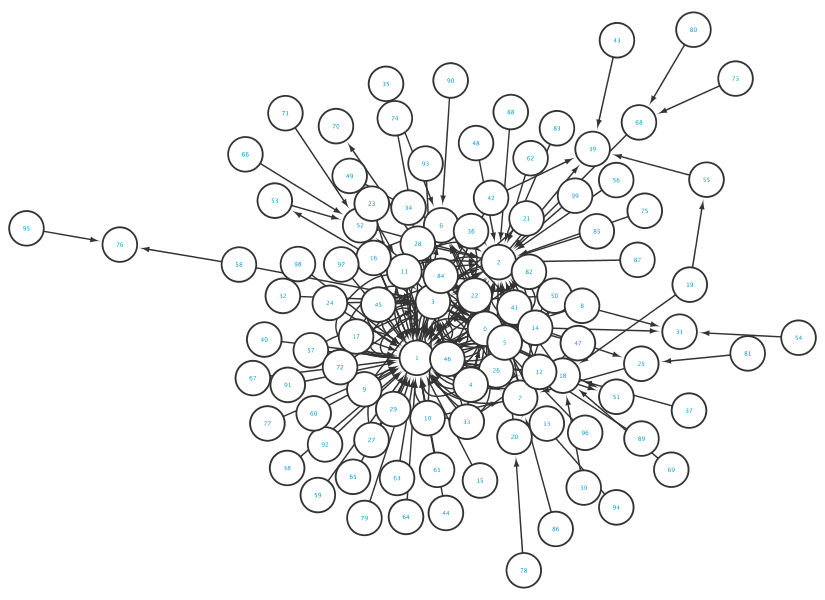

In [3]:
network_image_url = BASE_URL+ 'networks/' + str(suids[0]) + '/views/first.png'

print('\n\nThe network Image is available here: ' + network_image_url + '\n\n\n')
Image(network_image_url)

# Use External Services
----

## What is this (messy) code doing?
* Search KEGG Disease database to get list of cancer types
* Get list of pathways related to those cancers
* Feed the list of KEGG pathways to Cytoscape and visualize them

## Agents working in this workflow
* __Cytoscape__ - Visualizer & KEGG data reader
* __IPython Notebook__ - Conductor
* __KEGG Pathway Database__ - External Service
* __KEGG Disease Database__ - External Service
* __KEGG API__ - External Service

In [4]:
import io

# KEGG API
KEGG_API_URL = 'http://rest.kegg.jp/'

# Find information about 'cancer' from KEGG disease database.
query = 'cancer'

res = requests.get(KEGG_API_URL + '/find/disease/' + query)
pathway_list = res.content.decode('utf8')

disease_df = pd.read_csv(io.StringIO(pathway_list), delimiter='\t',  header=None, names=['id', 'name'])
disease_df.head(10)

,id,name
0,ds:H00013,Small cell lung cancer
1,ds:H00014,Non-small cell lung cancer
2,ds:H00016,Oral cancer
3,ds:H00017,Esophageal cancer
4,ds:H00018,Gastric cancer
5,ds:H00019,Pancreatic cancer
6,ds:H00020,Colorectal cancer
7,ds:H00022,Bladder cancer
8,ds:H00023,Testicular cancer
9,ds:H00024,Prostate cancer


In [5]:
disease_ids = disease_df['id']
disease_urls = disease_ids.apply(lambda x: KEGG_API_URL + 'get/' + x)

def disease_parser(entry):
    lines = entry.split('\n')
    data = {}
    
    last_key = None
    for line in lines:
        if '///' in line:
            return data
        
        parts = line.split(' ')
        if parts[0] is not None and len(parts[0]) != 0:
            last_key = parts[0]
            data[parts[0]] = line.replace(parts[0], '').strip()
        else:
            last_val = data[last_key]
            data[last_key] = last_val + '|' + line.strip()
    return data   

result = []
for url in disease_urls:
        res = requests.get(url)
        rows = disease_parser(res.content)
        result.append(rows)
disease_df = pd.DataFrame(result)
pathways = disease_df['PATHWAY'].dropna().unique()

p_urls = []
for pathway in pathways:
    entries = pathway.split('|')
    for en in entries:
        url = KEGG_API_URL + 'get/' + en.split(' ')[0].split('(')[0] + '/kgml'
        p_urls.append(url)

In [6]:
disease_df = pd.DataFrame(result)
pathways = disease_df['PATHWAY'].dropna().unique()

p_urls = []
for pathway in pathways:
    entries = pathway.split('|')
    for en in entries:
        url = KEGG_API_URL + 'get/' + en.split(' ')[0].split('(')[0] + '/kgml'
        p_urls.append(url)

# Import all cancer pathways into Cytoscape from KEGG Pathway DB

In [7]:
def create_from_list(network_list):
    server_res = requests.post(BASE_URL + 'networks?source=url&collection=' + query, data=json.dumps(network_list), headers=HEADERS)
    return json.loads(server_res.content)

requests.delete(BASE_URL + 'networks')

url_list = list(set(p_urls))
pathway_suids = create_from_list(url_list)

# Embedded Visualization with Cytoscape.js

In [8]:
# Package to render networks in Cytoscape.js
from py2cytoscape import cytoscapejs as cyjs

res1 = requests.get(BASE_URL + 'styles/KEGG Style.json')
kegg_style = res1.json()

# Load local network files
kegg_url = BASE_URL + 'networks/' + str(pathway_suids[3]['networkSUID'][0])
net1 =  requests.get(kegg_url + '/views/first')

# Render it!
cyjs.render(net1.json(), style=kegg_style[0]['style'], background='white')

<IPython.core.display.Javascript object>